In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
import seaborn as sns
from imblearn.over_sampling import SMOTE
from joblib import dump
import random
import warnings
warnings.filterwarnings('ignore')

## Reading and Pre-Processing of Data 

In [2]:
input_x_train_file = "../datasets/drugs_x_train.csv"
input_y_train_file = "../datasets/drugs_y_train.csv"

df_x = pd.read_csv(input_x_train_file)
df_y = pd.read_csv(input_y_train_file)

In [3]:
y_labels = df_y.idxmax(1)

In [4]:
df_concat = pd.concat([df_x, y_labels], axis=1)
df_concat.rename(columns={df_concat.columns[-1]:'Drug Classification'}, inplace=True) 
df_concat

,Age,Na_to_K,Sex_F,Sex_M,BP_HIGH,BP_LOW,BP_NORMAL,Cholesterol_HIGH,Cholesterol_NORMAL,Drug Classification
0,0.593220,0.297736,0,1,0,0,1,0,1,Drug_DrugY
1,0.830508,0.458534,0,1,1,0,0,0,1,Drug_DrugY
2,0.796610,0.322878,0,1,0,0,1,1,0,Drug_DrugY
3,0.677966,0.147226,1,0,1,0,0,1,0,Drug_drugB
4,0.881356,0.144756,0,1,0,0,1,0,1,Drug_DrugY
...,...,...,...,...,...,...,...,...,...,...
129,0.118644,0.177747,0,1,0,0,1,1,0,Drug_DrugY
130,0.593220,0.201201,1,0,0,0,1,1,0,Drug_DrugY
131,0.237288,0.724905,1,0,1,0,0,1,0,Drug_DrugY
132,0.881356,0.300894,1,0,0,0,1,1,0,Drug_DrugY


## Feature Selection

However, since no features were highly correlated to each other, no feature was removed.

<AxesSubplot: >

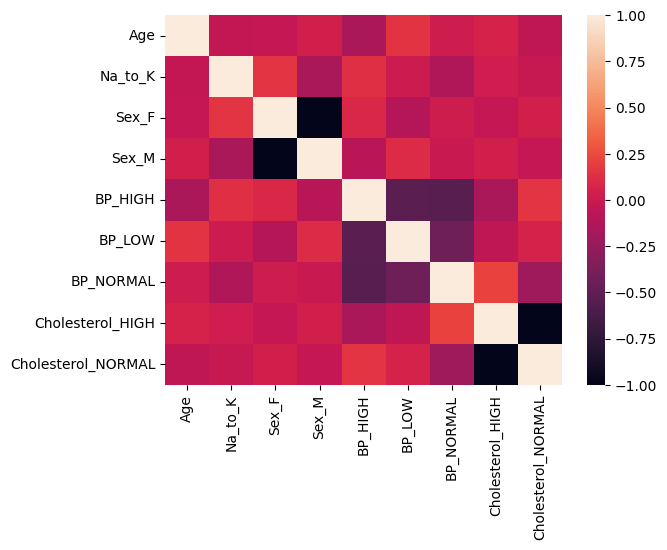

In [5]:
sns.heatmap(df_concat.corr())

## Train-Test Split

In [6]:
x_train, x_test, y_train, y_test = train_test_split(df_x, y_labels, test_size=0.20, random_state=1)

## SMOTE

Applying SMOTE (Synthetic Minority Over-sampling Technique) to prevent oversampled data

In [7]:
x_train, y_train = SMOTE().fit_resample(x_train, y_train)

## Model Selection

In [8]:
models = [
    LogisticRegression(), 
    MLPClassifier(), 
    KNeighborsClassifier(), 
    SVC(),
    GaussianProcessClassifier(), 
    DecisionTreeClassifier(), 
    RandomForestClassifier(), 
    AdaBoostClassifier(), 
    GaussianNB()
] 

In [9]:
for model in models:
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    print('\n\n' + str(model))
    print(f1_score(y_test, y_pred, average='macro'))



LogisticRegression()
0.7176444245409763


MLPClassifier()
0.7176444245409763


KNeighborsClassifier()
0.5217569786535303


SVC()
0.6267857142857143


GaussianProcessClassifier()
0.5217569786535303


DecisionTreeClassifier()
0.9365079365079365


RandomForestClassifier()
0.9365079365079365


AdaBoostClassifier()
0.45367132867132864


GaussianNB()
0.7392857142857142


## Hyperparameter Tuning 

RandomForestClassifier Tuning

In [10]:
def objective_function(x, y, x_validation, y_validation, params):
    model = RandomForestClassifier(
        n_estimators=params['n_estimators'],
        criterion='gini', 
        max_depth=params['max_depth'],
        min_samples_split=params['min_samples_split'],
        min_samples_leaf=params['min_samples_leaf'],
        max_features='sqrt'
    )

    model.fit(x, y)

    predictions = model.predict(x_validation)

    return f1_score(predictions, y_validation, average='macro')

In [11]:
num_samples = 20
best_params = None
current_loss = 1000

for i in range(num_samples):
    params = {
        'n_estimators' : random.randrange(5, 100, 5),
        'max_depth' : random.randrange(10, 100, 10),
        'min_samples_split' : random.randrange(1, 5, 1),
        'min_samples_leaf' : random.randrange(1, 5, 1),
    }

    loss = objective_function(x_train, y_train, x_test.values, y_test.values, params)
    print("Loss: {}".format(loss))

    if loss < current_loss:
        best_params = params
        current_loss = loss

print("Best Loss: {}".format(current_loss))
print("Best Params: {}".format(best_params))

Loss: 0.8394607843137255
Loss: 0.8813131313131313
Loss: 0.9365079365079365
Loss: 0.9365079365079365
Loss: 0.9365079365079365
Loss: 0.9365079365079365
Loss: 0.9365079365079365
Loss: 0.9365079365079365
Loss: 0.9365079365079365
Loss: 0.8813131313131313
Loss: 0.9365079365079365
Loss: 0.9365079365079365
Loss: 0.9365079365079365
Loss: 0.9365079365079365
Loss: 0.9365079365079365
Loss: 0.8813131313131313
Loss: 0.9365079365079365
Loss: 0.9365079365079365
Loss: 0.9365079365079365
Loss: 0.9365079365079365
Best Loss: 0.8394607843137255
Best Params: {'n_estimators': 5, 'max_depth': 40, 'min_samples_split': 1, 'min_samples_leaf': 1}


## Saving the Model

In [12]:
model = RandomForestClassifier(
        n_estimators=params['n_estimators'],
        criterion='gini', 
        max_depth=params['max_depth'],
        min_samples_split=params['min_samples_split'],
        min_samples_leaf=params['min_samples_leaf'],
        max_features='sqrt',
    )

model.fit(x_train, y_train)

predictions = model.predict(x_test.values)

print(classification_report(predictions, y_test.values))
print(f1_score(predictions, y_test.values, average='macro'))

              precision    recall  f1-score   support

  Drug_DrugY       1.00      1.00      1.00        16
  Drug_drugA       1.00      0.75      0.86         4
  Drug_drugB       0.80      1.00      0.89         4
  Drug_drugC       1.00      1.00      1.00         3

    accuracy                           0.96        27
   macro avg       0.95      0.94      0.94        27
weighted avg       0.97      0.96      0.96        27

0.9365079365079365


In [13]:
dump(model, '../models/rf_drugs.joblib')